In [1]:
%cd dialogue_sim

/home/kirill/Desktop/DGAC/dialogue_sim


In [2]:
from dialogue_sim.sim_metrics import MetricsEval
import pandas as pd
import numpy as np

In [5]:
import pickle

def max_acc(y_true, y_pred):
    grid = np.linspace(y_pred.min(), y_pred.max(), 200).reshape(1, -1)
    pred = (y_pred.reshape(-1, 1) > grid)*1
    acc = np.equal(y_true.reshape(-1,1), pred).mean(axis = 0)
    return max(acc.max(), 1 - acc.min())

with open("data/mwtrain_sbert.pkl", "rb") as file:
    train_dials = pickle.load(file)

with open("data/mwtest_sbert.pkl", "rb") as file:
    test_dials = pickle.load(file)

with open("data/ensemble.pkl", "rb") as file:
    automl = pickle.load(file)


In [6]:
def get_similarity(target_dial, dials, me = None, automl = automl):
    if me is None:
        me = MetricsEval()
    scores = []
    for dial in dials:
        metrics = me.get_metrics(target_dial, dial)
        scores.append(list(metrics.values()))
    scores = np.array(scores)
    df = pd.DataFrame(scores, columns = list(metrics.keys()))
    similarity = automl.predict(df)
    return similarity

def get_similar_dials(target_dial, dials, thresh = 0.5):
    similarity = get_similarity(target_dial, dials).data.ravel()
    is_similar = similarity > thresh
    sim_dials = [dials[i] for i, is_sim in enumerate(is_similar) if is_sim]
    return sim_dials

In [7]:
def get_coverage_ratio(dials, subset):
    ss = set(subset)
    ratio = []
    length = []
    for dial in dials:
        is_in = np.array([cl in ss for cl in dial.second_stage_clusters])
        ratio.append(is_in.mean())
        length.append(len(is_in))
    ratio = np.array(ratio)
    length = np.array(length)
    return (ratio * length).sum() / length.sum()

In [8]:
def get_neighborhood(dial, prob_thresh = 0.1):
    dial_clusters = dial.second_stage_clusters
    transitions = dial.transitions
    res = set()
    for cluster in dial_clusters:
        cur_tr = transitions[cluster]
        near_cl = np.arange(0, len(cur_tr))[cur_tr > prob_thresh]
        res = res.union(set(near_cl))
        res = res.union(set([cluster]))
    return res

In [9]:
targ_dial = test_dials[0]

nh = get_neighborhood(targ_dial)
sim_dials = get_similar_dials(targ_dial, test_dials)
get_coverage_ratio(sim_dials, nh)

0.548113038812377

In [10]:
sim_dials = get_similar_dials(targ_dial, test_dials)
num_clusters = targ_dial.transitions.shape[0]

size = []
ratio = []
thresh_range = np.arange(0.0, 1.01, 0.05)

for thresh in thresh_range:
    nh = get_neighborhood(targ_dial, thresh)
    size.append(len(nh) / num_clusters)
    cr = get_coverage_ratio(sim_dials, nh)
    ratio.append(cr)

size = np.array(size)
ratio = np.array(ratio)

<Axes: >

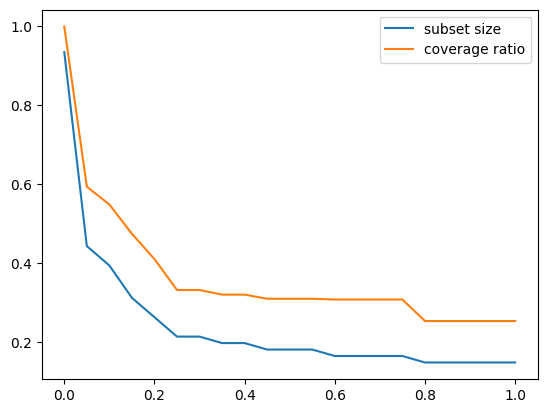

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = thresh_range, y = size, label = "subset size")
sns.lineplot(x = thresh_range, y = ratio, label = "coverage ratio")

In [12]:
from collections import Counter
c = Counter()

for dial in sim_dials:
    for cluster in dial.second_stage_clusters:
        c[cluster] += 1

In [13]:
s = sum(c.values())
ratios = np.array(list(c.values())) / s

In [14]:
ratios.sort()
ratios = ratios[::-1]
ratios[:10]

array([0.06072259, 0.05464139, 0.05097478, 0.03460919, 0.03192631,
       0.03031658, 0.02790199, 0.0276337 , 0.02718655, 0.02664997])

<Axes: ylabel='Count'>

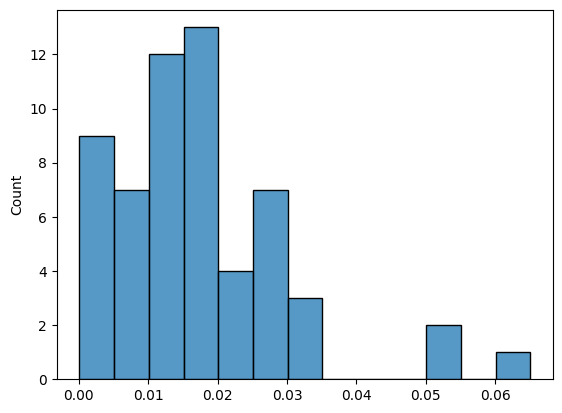

In [15]:
sns.histplot(ratios, binwidth = 0.005)

Text(0, 0.5, 'acc')

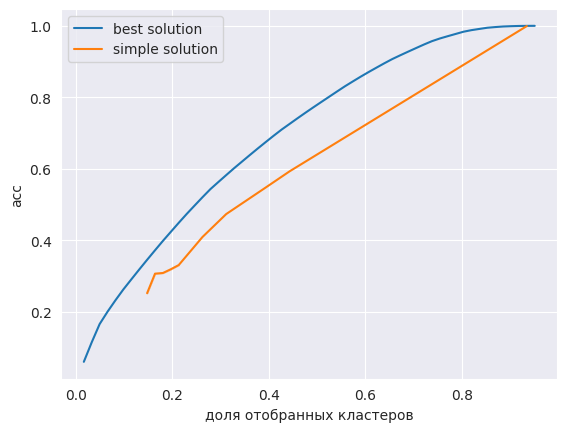

In [16]:
sns.set_style('darkgrid')
sns.lineplot(x = np.arange(1, len(ratios) + 1) / num_clusters, y = ratios.cumsum(), label = "best solution")
sns.lineplot(x = size, y = ratio, label = 'simple solution')
plt.xlabel("доля отобранных кластеров")
plt.ylabel('acc')

In [7]:
servs = set()
for d in train_dials:
    servs = servs.union(d.services)
serv_map = {s : i for i, s in enumerate(servs)}
vec_serv = np.zeros((len(train_dials), len(servs)))
for i, d in enumerate(train_dials):
    for s in d.services:
        id = serv_map[s]
        vec_serv[i][id] = 1

In [57]:
def serv_to_vec(services):
    res = np.zeros(len(servs))
    for serv in services:
        id = serv_map[serv]
        res[id] = 1
    return res

def get_similar(dial, vec_serv = vec_serv):
    cur_v = serv_to_vec(dial.services)
    sim = (vec_serv @ cur_v) > 0
    return sim

def get_best_subset_from_dials(dials, thresh = 0.75):
    res = np.zeros(num_clusters)
    for dial in dials:
        for cl in dial.second_stage_clusters:
            res[cl] += 1
    ratios = np.sort(res)[::-1] / res.sum()
    indexes = np.argsort(res)[::-1]
    csum = ratios.cumsum()
    best_subset = indexes[csum < thresh]
    return best_subset

def get_best_subset(dial, dials = train_dials, serv_matrix = vec_serv, thresh = 0.75):
    similar = get_similar(dial, serv_matrix)
    similar_ids = np.arange(0, len(dials))[similar]
    sim_dials = [dials[idx] for idx in similar_ids]
    bs = get_best_subset_from_dials(sim_dials, thresh)
    return bs

def get_ratios(dial, dials = train_dials, matrix = vec_serv):
    similar = get_similar(dial, matrix)
    similar_ids = np.arange(0, len(test_dials))[similar]
    sim_dials = [test_dials[idx] for idx in similar_ids]
    res = np.zeros(num_clusters)
    for dial in sim_dials:
        for cl in dial.second_stage_clusters:
            res[cl] += 1
    ratios = res / res.sum()
    return ratios

In [9]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

/home/kirill/Desktop/DGAC/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
num_clusters = train_dials[0].transitions.shape[0]

index = []
weights = []
for i in range(num_clusters):
    for j in range(num_clusters):
        if train_dials[0].transitions[i][j] > 0:
            index.append([i,j])
            weights.append(train_dials[0].transitions[i][j])
weights = torch.Tensor(weights)
edge_index = torch.Tensor(index).T.contiguous().long()

def get_data(dial, dials = train_dials, serv_matrix = vec_serv):
    x = torch.zeros((num_clusters, 1))
    for cl in dial.second_stage_clusters:
        x[cl][0] = 1
    edge_weight = torch.Tensor(dial.transitions)
    y = torch.zeros((num_clusters, 1))
    for cl in get_best_subset(dial, dials, serv_matrix):
        y[cl][0] = 1
    return Data(x = x, edge_index = edge_index, edge_weight = weights, y = y)

In [12]:
d = get_data(train_dials[0])

In [13]:
from torch_geometric.nn import SimpleConv

sc = SimpleConv()
outp = sc(d.x, d.edge_index, d.edge_weight)

In [14]:
def train_loop(model, data, optimizer, loss, epochs = 1):
    for epoch in range(epochs):
        for i, dial in enumerate(data):
            dial_d = get_data(dial).to(device)
            preds = model(x = dial_d.x, edge_index = dial_d.edge_index, edge_weight = dial_d.edge_weight)
            probs = torch.sigmoid(preds)

            optimizer.zero_grad()
            l = loss(probs, dial_d.y)
            l.backward()
            optimizer.step()

            if i % 100 == 0:
                print(l.item())

In [15]:
from torch import nn
from torch_geometric import nn as gnn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = gnn.GCN(in_channels = 1, hidden_channels = 8, num_layers = 3, out_channels = 1).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.BCELoss()

train_loop(model, train_dials, optimizer, loss, 1)

0.6881455779075623


/tmp/ipykernel_51935/2194893451.py:18: RuntimeWarning: invalid value encountered in divide
  ratios = np.sort(res)[::-1] / res.sum()


0.6707231402397156
0.6318368315696716
0.5896130800247192
0.625616192817688
0.7060144543647766
0.6423618197441101
0.7323391437530518
0.5568553805351257
0.6693062782287598
0.5712143778800964
0.5560444593429565
0.4861830770969391
0.5142003893852234
0.6526404023170471
0.599812924861908
0.5677433013916016
0.5956814885139465
0.6111199855804443
0.6040768027305603
0.5331757664680481
0.5631758570671082
0.5617386698722839
0.6541539430618286
0.5391188859939575
0.5955841541290283
0.5336203575134277
0.5130066275596619
0.5653608441352844
0.6012167930603027
0.4814664125442505
0.4754277169704437
0.4776534140110016
0.5820130705833435
0.5078693628311157
0.474427193403244
0.5568178296089172
0.46359261870384216
0.5376558303833008
0.5268160700798035
0.5624375939369202
0.6593244075775146
0.5702748894691467
0.4680197536945343
0.4731418192386627
0.48332470655441284
0.5248847007751465
0.5929225087165833
0.536056399345398
0.49944859743118286
0.4963397979736328
0.48692163825035095
0.5375105738639832
0.5354644060

In [58]:
test_serv_matrx = np.array([serv_to_vec(dial.services) for dial in test_dials])

In [59]:
dial = test_dials[0]
model.eval()
data = get_data(dial, test_dials, test_serv_matrx).to(device)
preds = model(x =data.x, edge_index = data.edge_index,edge_weight= data.edge_weight)
proba = torch.sigmoid(preds)

In [85]:
def get_metrics_neighborhood(dial, ratios):
    size = []
    metric = []
    for thresh in np.arange(0.01, 0.4, 0.01):
        nh = np.array(list(get_neighborhood(dial, thresh)), dtype = 'int32')
        metric.append(ratios[nh].sum())
        size.append(len(nh) / num_clusters)
    return size, metric

In [88]:
ratios = get_ratios(dial, test_dials, test_serv_matrx)
nh_size, nh_metric = get_metrics_neighborhood(dial, ratios)

In [89]:
model_sorted = np.argsort(proba.cpu().detach().numpy().ravel())[::-1]

metric = []
subset_size = []
for i in range(1, len(model_sorted) + 1):
    selected_nodes = model_sorted[:i]
    metric.append(ratios[selected_nodes].sum())
    subset_size.append(i / len(model_sorted))

In [97]:
np.sort(ratios).cumsum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.80436697e-05,
       3.52174679e-04, 1.05652404e-03, 2.11304807e-03, 3.69783413e-03,
       5.54675119e-03, 8.89241064e-03, 1.23261138e-02, 1.69924282e-02,
       2.32435288e-02, 2.94946293e-02, 3.58337736e-02, 4.36696602e-02,
       5.32664201e-02, 6.30392675e-02, 7.30762458e-02, 8.31132242e-02,
       9.34143335e-02, 1.05036098e-01, 1.17274168e-01, 1.30216587e-01,
       1.43423138e-01, 1.56805776e-01, 1.70276457e-01, 1.84803663e-01,
       1.99418912e-01, 2.14122205e-01, 2.29177672e-01, 2.44497271e-01,
       2.59904913e-01, 2.75400599e-01, 2.91160416e-01, 3.08064800e-01,
       3.25937665e-01, 3.43898574e-01, 3.61859482e-01, 3.80260609e-01,
       3.98749780e-01, 4.18295475e-01, 4.37929213e-01, 4.57650995e-01,
       4.79926043e-01, 5.03081528e-01, 5.26677232e-01, 5.51593590e-01,
       5.76597993e-01, 6.01778482e-01, 6.28191583e-01, 6.54604684e-01,
       6.81898222e-01, 7.09543934e-01, 7.37277690e-01, 7.67212537e-01,
      

<Axes: >

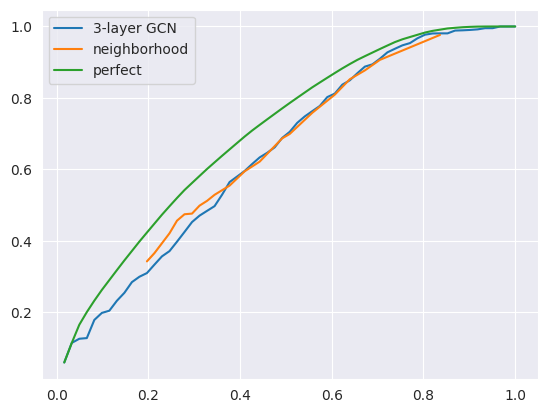

In [99]:
import seaborn as sns

sns.set_style('darkgrid')
sns.lineplot(x = subset_size, y = metric, label = '3-layer GCN')
sns.lineplot(x =  nh_size, y = nh_metric, label = 'neighborhood')
sns.lineplot(x = np.arange(1, num_clusters + 1) / num_clusters, y = np.sort(ratios)[::-1].cumsum(), label = 'perfect')